In [23]:
import torch
from torch import nn
import torchmetrics
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED
                            )
# Turn data into PyTorch tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Split data into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

In [3]:
X_blob[:5], y_blob[:20]

(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815]]),
 tensor([3, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 3, 0, 2, 2, 2, 0, 0, 0, 1]))

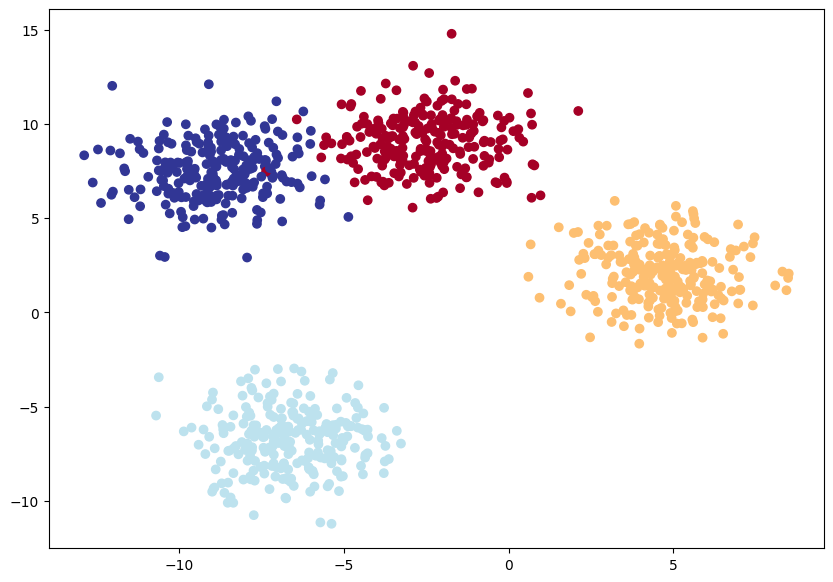

In [4]:
# Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [14]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [7]:
# Creating a multi-class classification model in PyTorch
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    
BlobNet = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
BlobNet

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [8]:
# Set up the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=BlobNet.parameters(), lr=0.1)

In [9]:
BlobNet.eval()
with torch.inference_mode():
    y_logits = BlobNet(X_blob_test.to(device))
y_logits[:10]

tensor([[ 0.0639, -0.3667, -0.1585,  0.1034],
        [ 0.3102, -0.6056, -0.2810, -0.3775],
        [ 0.6149, -0.0329,  0.1077,  0.1462],
        [ 0.1691, -0.4112,  0.0537,  0.0569],
        [-0.0175, -0.3242, -0.1875,  0.2697],
        [ 0.4354, -0.7068, -0.3580, -0.4930],
        [ 0.8800, -0.0582,  0.5298,  0.3843],
        [-0.0360, -0.3780, -0.1813,  0.1555],
        [ 0.6480, -0.0658, -0.2232, -0.0988],
        [-0.0473, -0.3565, -0.1905,  0.1919]], device='cuda:0')

In [10]:
# Convert the model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[0.2864, 0.1862, 0.2293, 0.2980],
        [0.4071, 0.1629, 0.2254, 0.2046],
        [0.3635, 0.1902, 0.2189, 0.2275],
        [0.2990, 0.1674, 0.2664, 0.2673],
        [0.2556, 0.1881, 0.2156, 0.3407],
        [0.4616, 0.1473, 0.2088, 0.1824],
        [0.3697, 0.1447, 0.2605, 0.2252],
        [0.2641, 0.1876, 0.2284, 0.3199],
        [0.4198, 0.2056, 0.1757, 0.1989],
        [0.2583, 0.1896, 0.2239, 0.3281]], device='cuda:0')

In [11]:
# logits to prediction probabilities to prediction labels
torch.argmax(y_pred_probs[0])

tensor(3, device='cuda:0')

In [12]:
# Put data to target device(gpu here)
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

In [13]:
# training the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

for epoch in range(epochs):
    BlobNet.train()
    
    y_logits = BlobNet(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    BlobNet.eval()
    with torch.inference_mode():
        test_logits = BlobNet(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch + 1} | Loss: {loss: .4f}, Acc: {acc: .2f}% | Test loss: {test_loss: .4f}, Test acc: {test_acc: .2f}%")

Epoch: 10 | Loss:  0.8500, Acc:  71.25% | Test loss:  0.7530, Test acc:  77.00%
Epoch: 20 | Loss:  0.3670, Acc:  96.62% | Test loss:  0.3030, Test acc:  99.50%
Epoch: 30 | Loss:  0.1754, Acc:  99.25% | Test loss:  0.1423, Test acc:  99.50%
Epoch: 40 | Loss:  0.0998, Acc:  99.25% | Test loss:  0.0811, Test acc:  99.50%
Epoch: 50 | Loss:  0.0705, Acc:  99.25% | Test loss:  0.0567, Test acc:  99.50%
Epoch: 60 | Loss:  0.0564, Acc:  99.25% | Test loss:  0.0446, Test acc:  99.50%
Epoch: 70 | Loss:  0.0484, Acc:  99.25% | Test loss:  0.0375, Test acc:  99.50%
Epoch: 80 | Loss:  0.0434, Acc:  99.25% | Test loss:  0.0329, Test acc:  99.50%
Epoch: 90 | Loss:  0.0399, Acc:  99.25% | Test loss:  0.0298, Test acc:  99.50%
Epoch: 100 | Loss:  0.0374, Acc:  99.25% | Test loss:  0.0274, Test acc:  99.50%


In [16]:
# Making and evaluating predictions with the PyTorch multi-class model
BlobNet.eval()
with torch.inference_mode():
    y_logits = BlobNet(X_blob_test)
y_logits[:10]

tensor([[  1.7877,   7.0594,  -6.3061,  -6.3440],
        [  1.7847,  -9.1503,  -1.9630,   6.4071],
        [  0.8809,  -0.6170,   9.0146,   1.5190],
        [  0.6093,   4.2517,  -3.4873,  -3.7255],
        [  5.0428,   0.5337,  -8.6490,  -4.1496],
        [  2.1499, -10.9139,  -2.2333,   7.6904],
        [  1.1470,  -0.5970,   8.8553,   1.1835],
        [  4.5190,  -2.2508,  -6.7467,  -1.8716],
        [  0.6802,  -0.6853,   9.8742,   1.9908],
        [  4.6127,  -1.1933,  -7.3032,  -2.6594]], device='cuda:0')

In [17]:
# Go from logits to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[5.1085e-03, 9.9489e-01, 1.5603e-06, 1.5023e-06],
        [9.7313e-03, 1.7345e-07, 2.2937e-04, 9.9004e-01],
        [2.9321e-04, 6.5565e-05, 9.9909e-01, 5.5505e-04],
        [2.5501e-02, 9.7374e-01, 4.2405e-04, 3.3417e-04],
        [9.8901e-01, 1.0887e-02, 1.1193e-06, 1.0070e-04],
        [3.9092e-03, 8.2895e-09, 4.8807e-05, 9.9604e-01],
        [4.4867e-04, 7.8437e-05, 9.9901e-01, 4.6533e-04],
        [9.9717e-01, 1.1447e-03, 1.2769e-05, 1.6726e-03],
        [1.0160e-04, 2.5933e-05, 9.9950e-01, 3.7678e-04],
        [9.9630e-01, 2.9983e-03, 6.6585e-06, 6.9205e-04]], device='cuda:0')

In [18]:
# Go from prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10], y_blob_test[:10]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'))

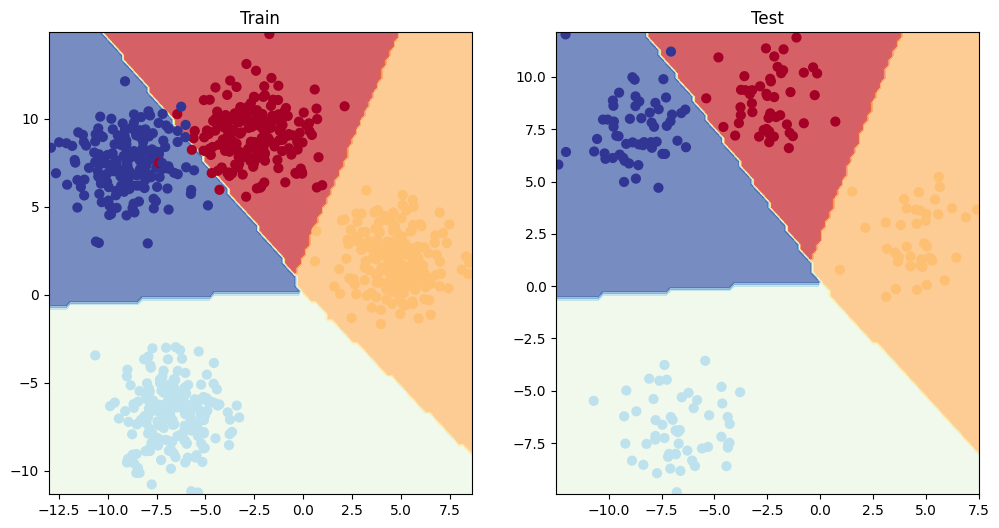

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(BlobNet, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(BlobNet, X_blob_test, y_blob_test)

In [31]:
# Calculating accuracy score using torchmetrics library
torchmetric_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4).to(device)
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

In [32]:
# Calculating the precision 
torchmetric_precision = torchmetrics.Precision(task="multiclass", num_classes=4).to(device)
torchmetric_precision(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')